In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

$$a(\theta) = \exp{\left(j2...\right)}$$

$$b(\tau) = \exp{\left(-j2\pi\Delta f (k-1)\tau\right)}$$

$$\Delta f = \dfrac{B}{N_f - 1}, \quad\text{and}\quad\tau = \dfrac{k-1}{B}$$

$$
\begin{aligned}
 b(\tau) &= \exp{\left(-j2\pi\Delta f (k-1)\tau\right)} \\
 &= \exp{\left(-j2\pi\Delta \dfrac{B}{N_f - 1} (k-1)\dfrac{k-1}{B}\right)} \\
 &= \exp{\left(-j2\pi(N_f - 1)(k-1)^2\right)}
\end{aligned}
$$

In [2]:
def getSubarray(N_row, N_col, L1, L2, L3, idx=[0, 0, 0]):
    # Array with all samples
    array = np.linspace(0, N_row * N_col-1, N_row * N_col, dtype=int).reshape((N_col, N_row))
    
    # Generate sub array
    idx_array = array[idx[0]:L1+idx[0], idx[1]:L2+idx[1]].reshape(1, -1)[0]

    # Generate sample sub array
    idx_n = np.arange(idx[2], idx[2] + L3)

    return idx_array, idx_n
    
def delay_response_vector_naive(az, tau, r, f, wave):
    a = np.zeros(r.shape[1], dtype=complex)
    e = np.matrix([np.cos(az), np.sin(az)])

    for i in range(len(a)):
        a[i] = np.exp(2j * np.pi * wave * np.dot(e, r[:, i]))
    
    b = np.zeros(len(f), dtype=complex)
    for i in range(len(b)):
        b[i] = np.exp(-2j * np.pi * f[i] * tau)

    return np.kron(b, a)

def delay_response_vector(az, tau, r, f, wave):
    # Angle
    e = np.matrix([np.cos(az), np.sin(az)])
    a = np.exp(2j * np.pi * (1 / wave) * np.dot(e, r)).T
    
    # Time delay
    b = np.exp(-2j * np.pi * f * tau)
    
    return np.kron(b, a)

def get_noise(x, SNR_dB=5):
    L, N = x.shape
    SNR = 10.0**(SNR_dB / 10.0) # Desired linear SNR
    xVar = x.var() # Power of signal
    print('var = ', xVar)
    #print(x.conj().T * x / len(x))
    nVar = xVar / SNR # Desired power of noise
    n = np.random.normal(0, np.sqrt(nVar*2.0)/2.0, size=(L, 2*N)).view(complex)
    return n

var =  349.1382895044791
X: (16, 101), r: (2, 16)
f: (101, 1)
r: (2, 16)
0 / 100
1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 / 100
55 / 100
56 / 100
57 / 100
58 / 100
59 / 100
60 / 100
61 / 100
62 / 100
63 / 100
64 / 100
65 / 100
66 / 100
67 / 100
68 / 100
69 / 100
70 / 100
71 / 100
72 / 100
73 / 100
74 / 100
75 / 100
76 / 100
77 / 100
78 / 100
79 / 100
80 / 100
81 / 100
82 / 100
83 / 100
84 / 100
85 / 100
86 / 100
87 / 100
88 / 100
89 / 100
90 / 100
91 / 100
92 / 100
93 / 100
94 / 100
95 / 100
96 / 100
97 / 100
98 / 100
99 / 100


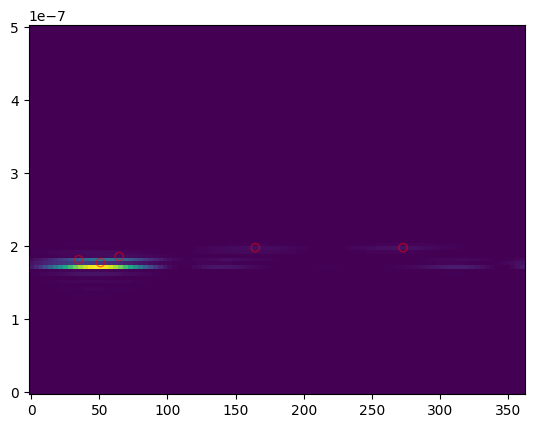

In [3]:
# Given parameters
SNR_dB = 50
N_rows = 71
N_cols = 66

# Subarray
L1 = 4 # Number of column elements in subarray 
L2 = 4 # Number of row elements in subarray
L3 = 101 # Number of subsamples
offset = [0, 0, 0] # Starting point of subarray (L1_0, L2_0, L3_0)
idx_array, idx_n = getSubarray(N_rows, N_cols, L1, L2, L3, offset)

# Load data
data = loadmat('MeasurementforMiniproject.mat')
X = data['X_synthetic'][idx_array][:, idx_n]
X += get_noise(X, SNR_dB)

r = data['r'][:, idx_array]
#f = data['f'][idx_n]
f = np.arange(len(idx_n)).reshape(len(idx_n), 1)
f0 = data['f0'][0, 0]

# Calculated parameters
samples = len(f)
wave = 3e8 / f0

print(f'X: {X.shape}, r: {r.shape}')
print('f:', f.shape)
print('r:', r.shape)

# Time-delay parameters
K = 100
tau_max = 5e-7
tau_search = np.linspace(start=0, stop=1, num=K, endpoint=True)

# AoA parameters
D = 100
az_search = np.linspace(start=0, stop=2*np.pi, num=D, endpoint=True)

# Power spectrum
Pb = np.zeros((K, D), dtype=complex)
X = X.flatten(order='F').reshape(len(X.flatten(order='F')), 1, order='F')
Rxx = X @ (np.conjugate(X).T)

for i in range(D):
    print(i, '/', D)
    for j in range(K):

        mu = delay_response_vector(az_search[i], tau_search[j], r, f, wave)

        Pb[j, i] = np.abs((mu.conj().T @ Rxx @ mu) / np.linalg.norm(mu)**4)

fig, ax = plt.subplots()
ax.pcolormesh(np.rad2deg(az_search), tau_search * tau_max, np.abs(Pb))

#true_angles = np.rad2deg(data['smc_param'][0][0][1])
#true_angles[true_angles < 0] = true_angles[true_angles < 0] + 360

AoA = (data['smc_param'][0][0][1])*180/np.pi
AoA[AoA < 0] = AoA[AoA < 0] + 360
TDoA = (data['smc_param'][0][0][2])*(1/3e8) + np.abs(data['tau'][0])
ax.scatter(AoA, TDoA, color='r', marker='o', facecolors='none', alpha=1/2)

In [4]:
# Given parameters
N_rows = 71
N_cols = 66
L1 = 15
L2 = 15
L3 = 101
idx_array, idx_n = getSubarray(N_rows, N_cols, L1, L2, L3)

print(idx_array.shape, (idx_array.reshape(len(idx_array))).shape)

# Load data
data = loadmat('MeasurementforMiniproject.mat')
X = data['X_synthetic'][idx_array][:, idx_n]
r = data['r'][:, idx_array]
f = data['f'][idx_n]
f0 = data['f0'][0, 0]
tau = data['tau']

print(tau[1] - tau[0])

print(data['smc_param'][0][0][0])
print(np.rad2deg(data['smc_param'][0][0][1]))

true_angles = np.rad2deg(data['smc_param'][0][0][1])
true_angles[true_angles < 0] = true_angles[true_angles < 0] + 360


print(data['smc_param'][0][0][2])

(225,) (225,)
[5.e-09]
[[5]]
[[ 50.88252107]
 [ 34.82704776]
 [164.39983394]
 [-87.30614871]
 [ 64.56419748]]
[[3.23578932]
 [4.39589382]
 [9.33539943]
 [9.35254152]
 [5.7079572 ]]
